## Introduction

This notebook explores the use of unsupervised clustering techniques to assess whether natural groupings among firms could support the construction of a prospectability scoring framework. The intended objective is to determine whether company-level financial and operational features can be leveraged to segment firms in a way that meaningfully distinguishes highly prospective candidates from less promising ones, with the longer-term goal of informing a continuous score ranging from 0 to 100 and identifying top and bottom subsets of companies.

After preliminary data preparation and inspection, which substantially reduced the initial dataset due to outdated financial information and high rate of missing data, clustering methods including k-means and density-based algorithms are applied and evaluated. Particular attention is paid to feature scale heterogeneity, outlier behaviour, and the structural assumptions imposed by each clustering method.

Rather than presupposing that prospectability emerges naturally as a segmentation problem, this notebook critically examines whether the data exhibit intrinsic cluster structure suitable for ranking or scoring purposes. The results are therefore interpreted in terms of their relevance for scoring design.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.impute import KNNImputer

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

from pathlib import Path

pd.set_option('display.max_rows', 40)

# Set path to datasets
DATA_DIR = Path("/home/tella/code/StellaRodriguesLallement/OSE_Project/ose-main/src/ose_core/data/data_stella/")


In [2]:
# Load KPI data
df_kpi_feat = pd.read_parquet(DATA_DIR / "df_kpi_feat.parquet")

df_kpi_feat.shape

(1165, 9)

In [3]:
df_kpi_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1165 entries, 0 to 1164
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   company_name           1165 non-null   object 
 1   siren                  1165 non-null   object 
 2   siret                  1165 non-null   object 
 3   fonds_propres          1165 non-null   float64
 4   ca_bilan               1133 non-null   float64
 5   resultat_exploitation  999 non-null    float64
 6   resultat_bilan         1160 non-null   float64
 7   annee                  1165 non-null   float64
 8   effectif               1093 non-null   float64
dtypes: float64(6), object(3)
memory usage: 82.0+ KB


In [4]:
df_kpi_feat.head(3)

,company_name,siren,siret,fonds_propres,ca_bilan,resultat_exploitation,resultat_bilan,annee,effectif
0,LE COQ NOIR,316203942,31620394200024,1145201.0,4102063.0,483701.0,29766.0,2024.0,35.0
1,BONDUELLE TRAITEUR INTERNATIONAL,957802416,95780241600058,-384750.0,117018336.0,-3019716.0,-4189725.0,2024.0,375.0
2,TRAITEUR DU VAL DE CERE,340241496,34024149600025,4575601.0,4430862.0,176000.0,106404.0,2024.0,41.0


In [5]:
df_kpi_feat.isna().mean().sort_values(ascending=False)

resultat_exploitation    0.142489
effectif                 0.061803
ca_bilan                 0.027468
resultat_bilan           0.004292
company_name             0.000000
fonds_propres            0.000000
siret                    0.000000
siren                    0.000000
annee                    0.000000
dtype: float64

## Diagnostics informing scaling and imputation strategy

In [6]:
num_cols = [
    'fonds_propres',
    'ca_bilan',
    'resultat_exploitation',
    'resultat_bilan',
    'effectif',
]

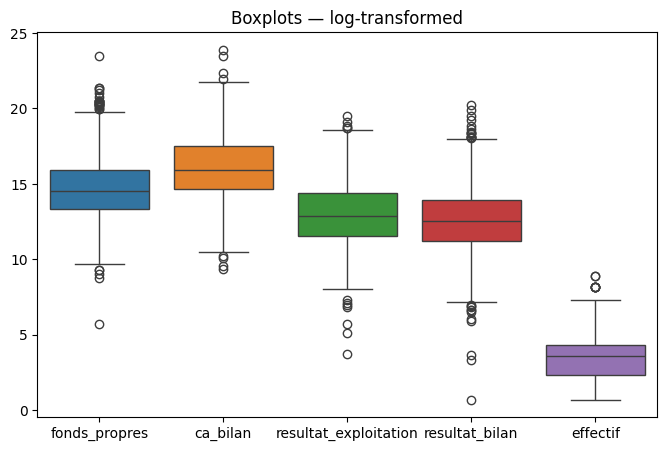

In [7]:
plt.figure(figsize=(8, 5))
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    sns.boxplot(data=df_kpi_feat[num_cols].apply(lambda x: np.log1p(x)))

plt.title("Boxplots — log-transformed")
plt.show()

**Diagnostic note**

A log1p transform is applied here purely as a diagnostic tool to visualise skewness and tail behaviour across heterogeneous numerical features, not as a definitive preprocessing choice.

**Conclusion**

The log-transformed boxplots reveal persistent heavy tails, widespread outliers, and strong scale heterogeneity across features, ruling out standard scaling and mean-based imputation. These diagnostics motivate the use of **RobustScaler** to limit the influence of extreme values. Missing values should be handled using imputation strategies that preserve relative scale and inter-firm differentiation rather than introducing global central values that collapse economically distinct firm profiles.

In this context, **distance-based KNN-based imputation** is preferable, as it infers missing values conditionally from economically similar firms and better preserves structural heterogeneity in the feature space, provided that robust scaling is applied prior to distance computation.

## Pipeline --> RobustScaler + KNNImputer

In [8]:
X = df_kpi_feat[num_cols]

preprocess = Pipeline([
    ("scaler", RobustScaler()),
    ("imputer", KNNImputer(n_neighbors=5))
])

X_preprocessed = preprocess.fit_transform(X)

np.isnan(X_preprocessed).sum()

np.int64(0)

## The Elbow method for selecting k

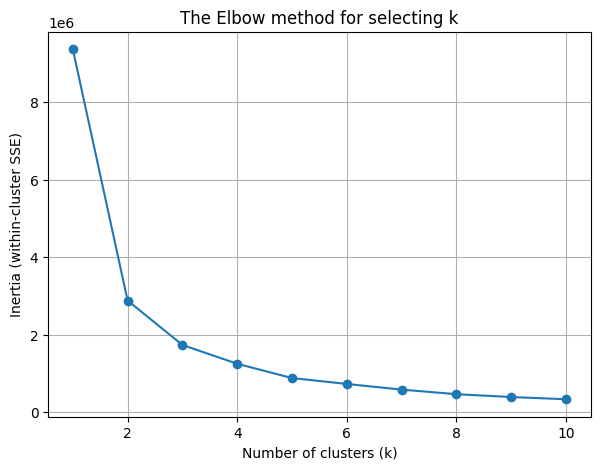

In [9]:
inertias = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_preprocessed)
    inertias.append(km.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(K_range, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("The Elbow method for selecting k")
plt.grid(True)
plt.show()


There is a very sharp drop in inertia from **k = 1** to **k = 2**, indicating strong evidence that more than one cluster is required. Beyond **k = 5**, reductions in within-cluster variance become marginal, suggesting diminishing returns from adding further clusters. Consequently, **k = 4** represents a reasonable trade-off between model complexity and explained variance.

In [10]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_preprocessed)

In [11]:
df_model = df_kpi_feat.copy()
df_model["cluster"] = clusters

## Cluster Analysis

In [12]:
df_model.groupby('cluster')[num_cols].mean()

,fonds_propres,ca_bilan,resultat_exploitation,resultat_bilan,effectif
cluster,,,,,
0,1.382328e+07,6.469356e+07,1.036942e+06,1.618609e+05,99.902622
1,1.572000e+10,1.030000e+09,-1.190000e+08,5.920000e+08,1500.000000
2,6.975449e+08,2.063478e+09,5.766372e+07,6.734412e+07,1647.380952
3,6.862924e+08,7.990904e+09,9.839556e+07,3.197478e+08,107.000000


The clustering reveals a dominant mass of companies with broadly similar financial profiles and a small number of extreme firms forming isolated clusters. This indicates strong scale effects and the presence of structural outliers, limiting the interpretability of standard K-Means clustering.

In [13]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_preprocessed)
centroids_pca = pca.transform(kmeans.cluster_centers_)

df_model["PC1"] = X_pca[:, 0]
df_model["PC2"] = X_pca[:, 1]

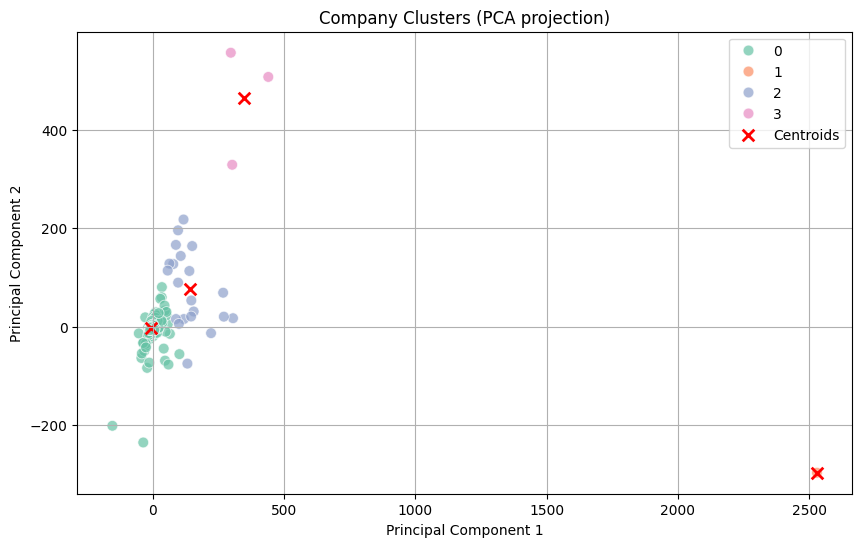

In [14]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_model,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="Set2",
    s=60,
    alpha=0.7
)

plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    c="red",
    marker="x",
    s=70,        # smaller than before
    linewidths=2,
    label="Centroids"
)

plt.title("Company Clusters (PCA projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
df_model['cluster'].value_counts().sort_index()

cluster
0    1140
1       1
2      21
3       3
Name: count, dtype: int64

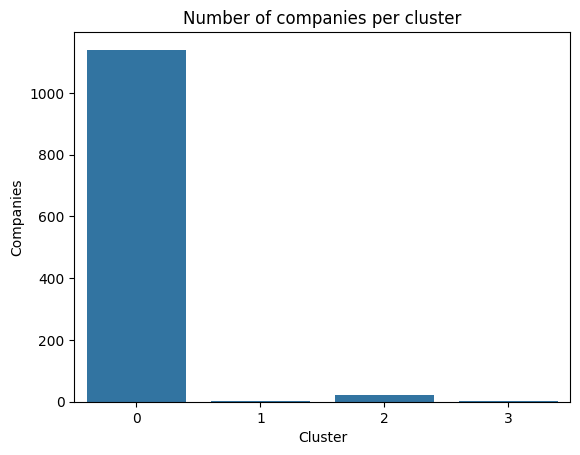

In [16]:
cluster_sizes = (
    df_model
    .groupby('cluster')
    .size()
    .reset_index(name='n_companies')
)

sns.barplot(
    x=cluster_sizes['cluster'],
    y=cluster_sizes['n_companies']
)
plt.title("Number of companies per cluster")
plt.xlabel("Cluster")
plt.ylabel("Companies")
plt.show()


While the PCA projection suggests several visually distinct groups, cluster size analysis reveals that the vast majority of companies belong to a single dominant cluster, with the remaining clusters capturing only a handful of extreme or atypical observations. This discrepancy reflects the projection effect of PCA, which provides a two-dimensional view of a high-dimensional clustering, and suggests that k-means may primarily isolate outliers rather than identify multiple balanced segments.

As DBSCAN is better suited for density-based clustering and explicit outlier detection without imposing a predefined number of clusters, it is used to evaluate whether the data exhibit intrinsic density-based structure rather than centroid-driven partitioning.

In [17]:
dbscan = DBSCAN(
    eps=2.0,
    min_samples=10
)

labels_db = dbscan.fit_predict(X_preprocessed)

df_model = df_kpi_feat.copy()
df_model["cluster"] = labels_db

print("Noise proportion:", np.mean(labels_db == -1))

Noise proportion: 0.20257510729613734


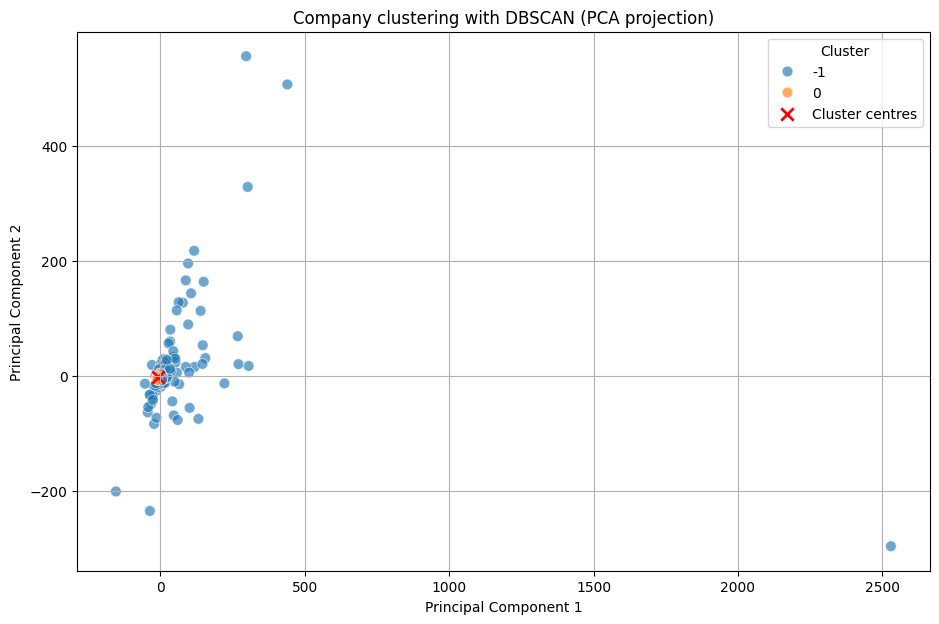

In [18]:
# PCA for visualisation only
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_preprocessed)

df_model["PC1"] = X_pca[:, 0]
df_model["PC2"] = X_pca[:, 1]


# Computing cluster centroids in PCA space, excluding noise = -1
centroids_pca = (
    df_model[df_model["cluster"] != -1]
    .groupby("cluster")[["PC1", "PC2"]]
    .mean()
    .reset_index()
)

# Visualisation
plt.figure(figsize=(11, 7))

sns.scatterplot(
    data=df_model,
    x="PC1",
    y="PC2",
    hue="cluster",
    palette="tab10",
    s=60,
    alpha=0.65,
    legend="full"
)

# Centroids
plt.scatter(
    centroids_pca["PC1"],
    centroids_pca["PC2"],
    marker="x",
    c="red",
    s=80,            # smaller than before
    linewidths=2,
    label="Cluster centres"
)

plt.title("Company clustering with DBSCAN (PCA projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


## Conclusion

This exploratory analysis assessed whether unsupervised clustering could provide a meaningful foundation for a prospectability scoring framework ranging from 0 to 100 and support the identification of top and bottom candidate companies. Across multiple specifications, both k-means and density-based approaches consistently revealed a highly imbalanced structure dominated by a single large cluster, with remaining clusters capturing only a small number of extreme or atypical observations. 

Results indicate limited intrinsic segmentation in the feature space and suggest that the models primarily isolate outliers rather than uncover economically coherent or gradable company groups. As a consequence, the clustering outputs do not support the construction of a continuous prospectability score or a robust ranking of firms. 

Findings highlight that prospectability in this context is not well modelled as an unsupervised segmentation problem and is more likely to require a supervised or criteria-driven scoring approach aligned with explicit business signals and outcome definitions, where historical outcomes provide the target variable for learning.

The strong reduction in sample size following data quality filtering further limits the emergence of stable cluster structure, reinforcing the conclusion that unsupervised segmentation is not well suited to this prospectability objective under the current data constraints.